# Prepare bird data
Create a CSV file containing the bird count for a given species.

In [280]:
using CSV
using PyPlot
using Dates
using DelimitedFiles
using DataFrames
using Test
const plt = PyPlot
using Conda
using PyCall
mpl = pyimport("matplotlib")
mpl.style.use("./emodnet.mplstyle")
ccrs = pyimport("cartopy.crs")
datacrs = ccrs.PlateCarree();

## Data
Downloaded from https://www.vliz.be/en/imis?module=dataset&dasid=3117. 

> Vanermen N, Stienen EWM, Fijn R, Markones N, Holdsworth N, Osypchuk A, Pinto C, Desmet P (2022): European Seabirds at Sea (ESAS). ICES, Copenhagen, Denmark. https://esas.ices.dk. https://doi.org/10.14284/601

Two files are processed:
- `event.txt`: it gives the data set ID, the position and the date
- `occurrence.txt`: it gives the count for different taxa, and relate them to the eventID read from the previous fole. 

In [282]:
domain = (-55, 21, 14., 80.)
doplot = false

myspecies = "Larus fuscus"

datadir = "/home/ctroupin/data/EMODnet/Biology/dwca-esas-v1.3"
outputdir = "../../data/"

datafileevent = joinpath(datadir, "event.txt")
datafileoccur = joinpath(datadir, "occurrence.txt")

# The "small" files, used for testing, are obtained by taking the first 200 lines of the 
# initial files
datafileevent2 = joinpath(datadir, "event_small.txt")
datafileoccur2 = joinpath(datadir, "occurrence200.csv")

isfile(datafileevent) & isfile(datafileoccur)

true

## Read data as dataframes
### Events

In [283]:
@time dataevents, header = readdlm(datafileevent, '\t', header=true);
events = DataFrame(dataevents, vec(header));

 26.594404 seconds (93.21 M allocations: 3.447 GiB, 74.16% gc time)


In [284]:
# Keep only sub-samples (otherwise no coordinates)
events = events[events.type .== "subSample",:];

### Occurences

In [285]:
@time dataoccur, header = readdlm(datafileoccur, '\t', header=true);
occurences = DataFrame(dataoccur, vec(header));

 55.111527 seconds (158.66 M allocations: 5.565 GiB, 84.25% gc time)


In [286]:
# Subset dataframe according to the select species
occurences_species = occurences[occurences.scientificName .== myspecies,:];

### Compute the total number of occurences per event

In [195]:
function get_total_count(occurences::DataFrame)
    
    total_count = Dict{String, Int64}()
    for (eventID, count) in zip(occurences.id, occurences_species.individualCount)
        @debug("$eventID → $count")

        # If the key was already found in the Dict, add the index to the list
        if haskey(total_count, eventID)
            total_count[eventID] += count
        else
            total_count[eventID] = count
        end
    end

    return total_count::Dict
end

get_total_count (generic function with 2 methods)

In [209]:
@time total_count = get_total_count(occurences_species);

  0.000059 seconds (273 allocations: 11.203 KiB)


In [198]:
function parse_date(xx::DataFrame, regexdate=r"\d{4}-\d{2}-\d{2}/\d{4}-\d{2}-\d{2}"::Regex)

    mm = match(regexdate, xx)
    if mm !== nothing
        datestring = mm.match[1:10]
    else
        datestring = xx
    end
    thedate = DateTime(datestring, thedateformat)
    return thedate::DateTime
end

parse_date (generic function with 3 methods)

In [199]:
transform!(events, "eventDate" => ByRow(parse_date) => "eventDate");

1553035-element Vector{DateTime}:
 1993-08-14T00:00:00
 1993-08-14T00:00:00
 1993-08-14T06:04:00
 1993-08-14T06:15:00
 1993-08-14T06:25:00
 1993-08-14T06:34:00
 1993-08-14T06:45:00
 1993-08-14T06:54:00
 1993-08-14T07:04:00
 1993-08-14T07:15:00
 1993-08-14T07:25:00
 1993-08-14T07:34:00
 1993-08-14T07:45:00
 ⋮
 2016-07-15T15:06:00
 2016-07-15T15:07:00
 2016-07-15T15:08:00
 2016-07-15T15:09:00
 2016-07-15T15:10:00
 2016-07-15T15:11:00
 2016-07-15T15:12:00
 2016-07-15T15:13:00
 2016-07-15T15:14:00
 2016-07-15T15:15:00
 2016-07-15T15:16:00
 2016-07-15T15:17:00

## Make some plots
### Histogram

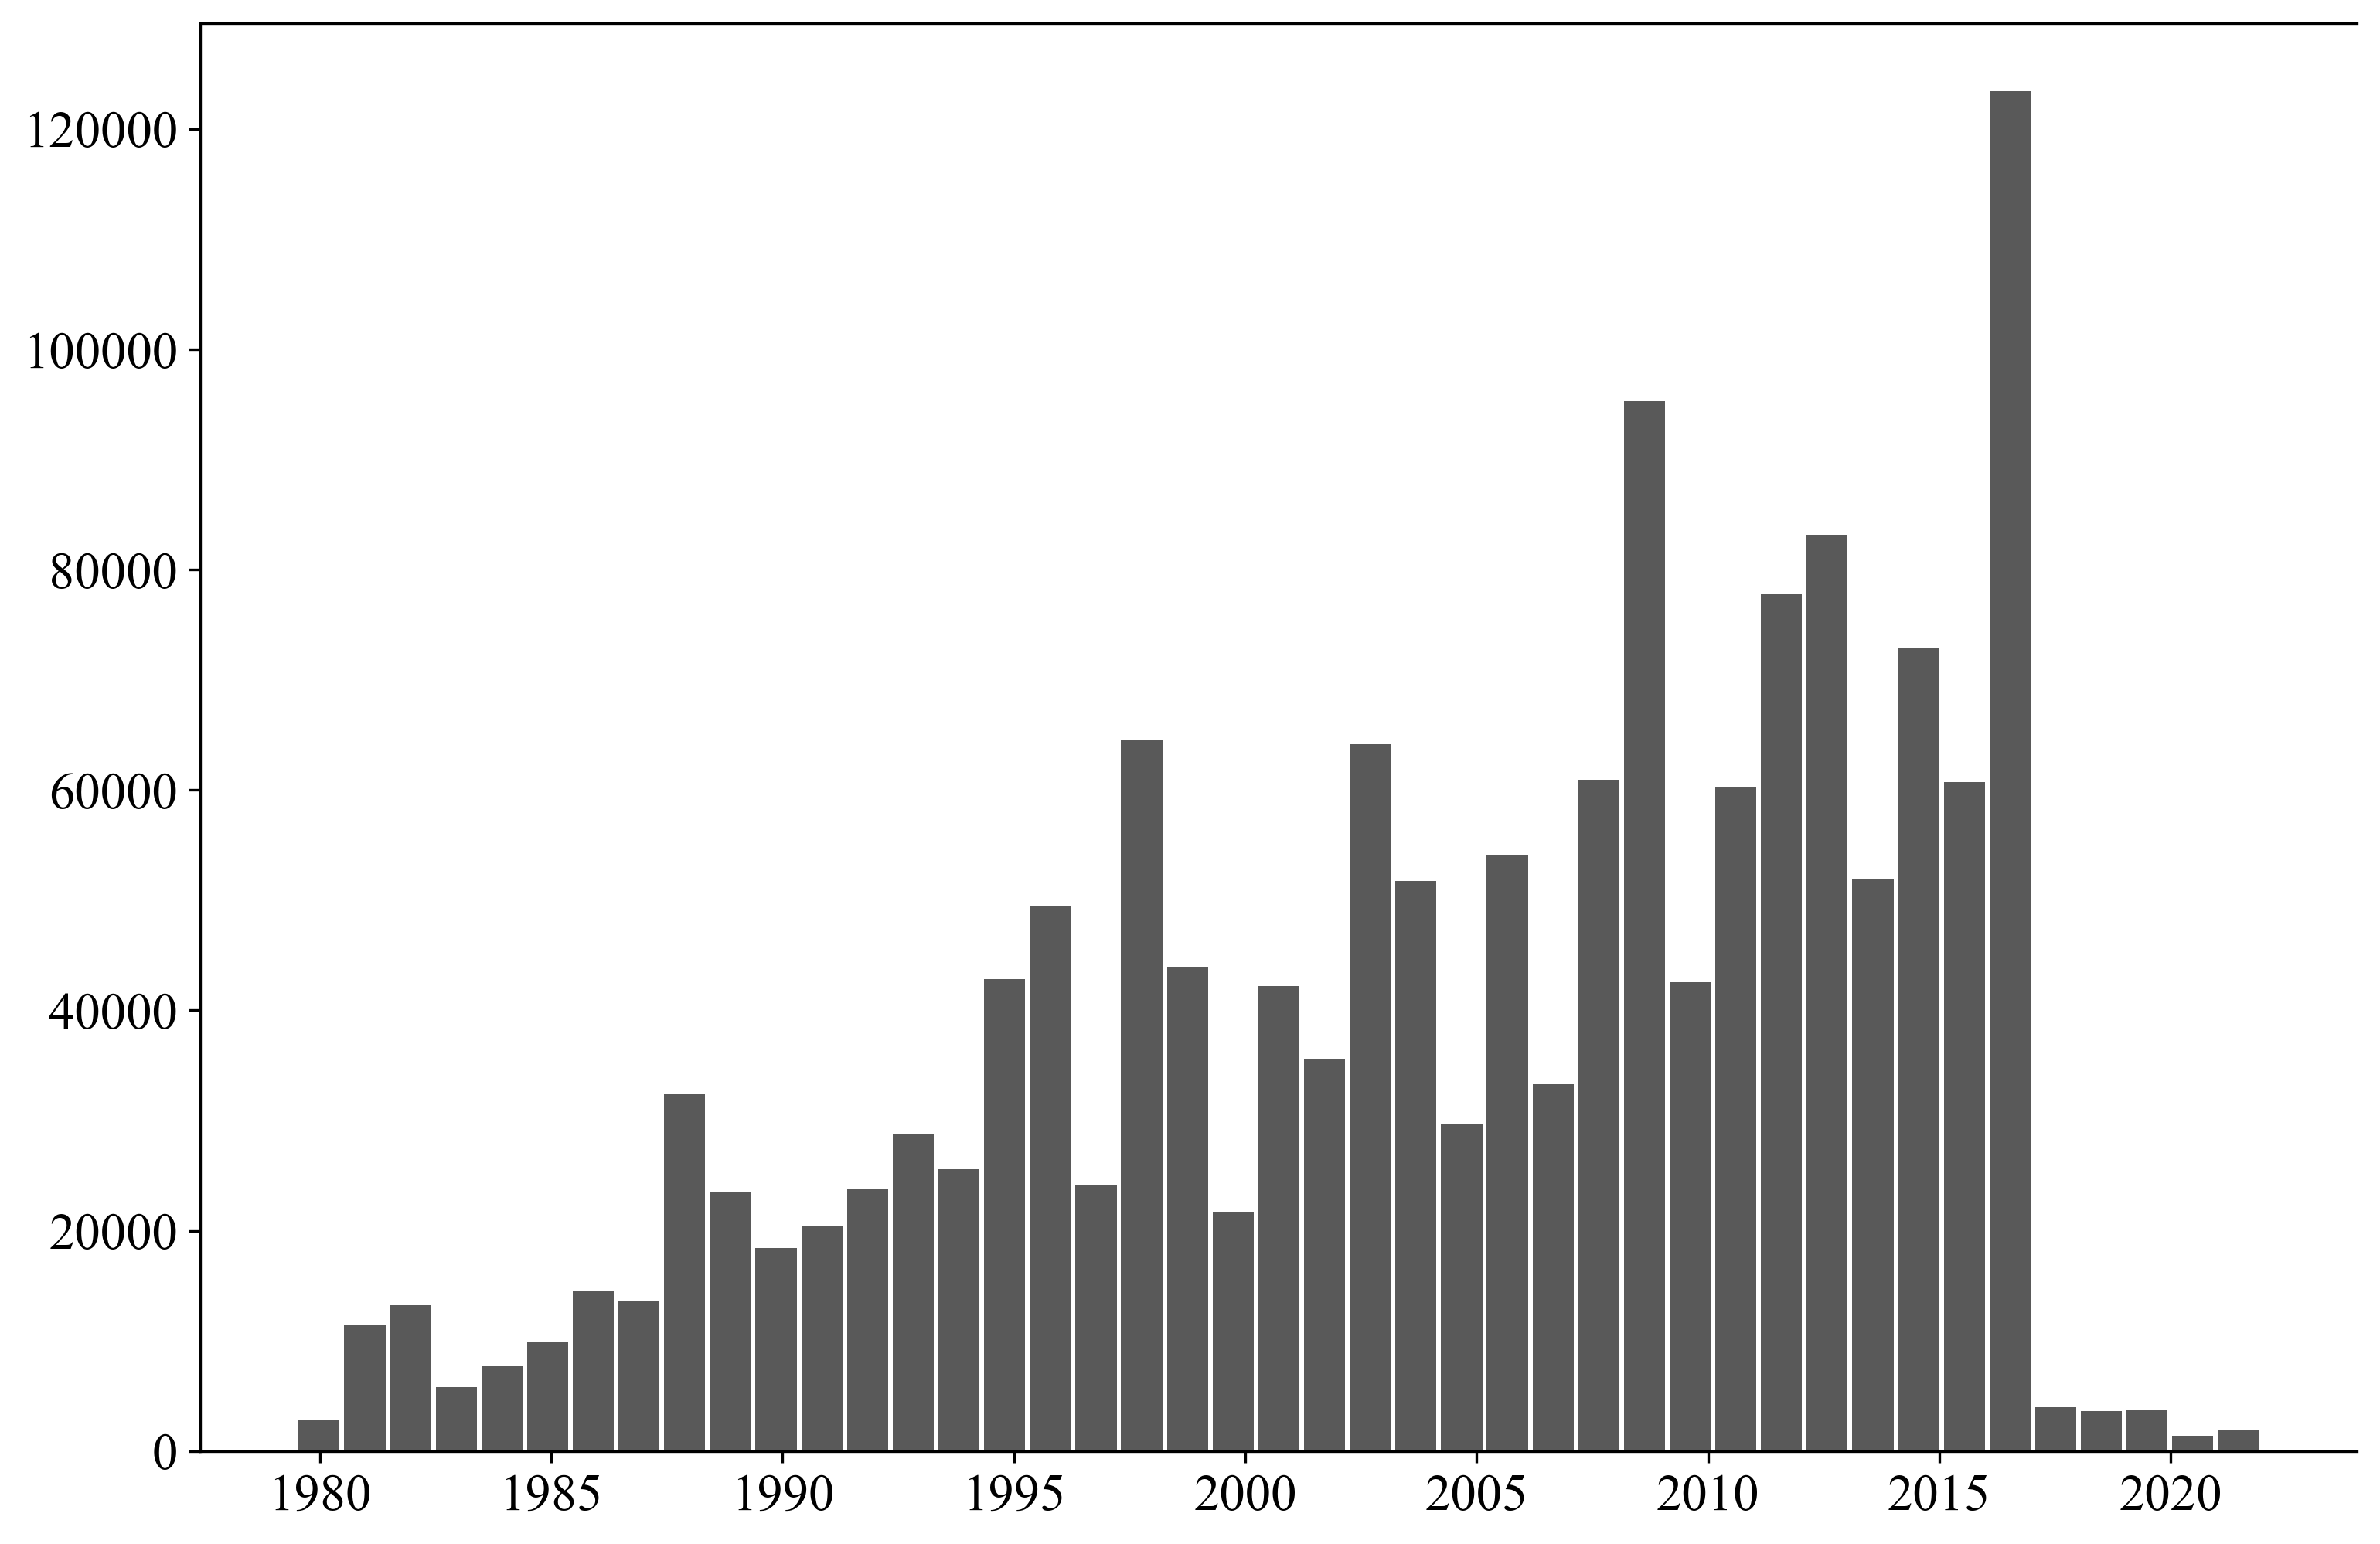

([2847.0, 11417.0, 13235.0, 5822.0, 7668.0, 9843.0, 14566.0, 13652.0, 32385.0, 23529.0  …  83165.0, 51904.0, 72958.0, 60698.0, 123432.0, 3957.0, 3655.0, 3780.0, 1383.0, 1860.0], [3466.0, 3826.7587855297156, 4187.517571059431, 4548.276356589147, 4909.035142118863, 5269.7939276485795, 5630.552713178295, 5991.311498708011, 6352.070284237727, 6712.829069767442  …  15731.798708010338, 16092.557493540053, 16453.316279069768, 16814.075064599485, 17174.833850129202, 17535.592635658915, 17896.351421188632, 18257.110206718346, 18617.868992248063, 18978.62777777778], (PyObject <matplotlib.patches.Rectangle object at 0x7b5821a34220>, PyObject <matplotlib.patches.Rectangle object at 0x7b57f9511690>, PyObject <matplotlib.patches.Rectangle object at 0x7b5821a34520>, PyObject <matplotlib.patches.Rectangle object at 0x7b5821a34760>, PyObject <matplotlib.patches.Rectangle object at 0x7b5821a34940>, PyObject <matplotlib.patches.Rectangle object at 0x7b5821a34b20>, PyObject <matplotlib.patches.Rectangle o

In [208]:
yearmin = minimum(Dates.year.(events.eventDate))
yearmax = maximum(Dates.year.(events.eventDate))
fig = plt.figure()
ax = plt.subplot(111)
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.hist(events.eventDate, bins=1-yearmin+yearmax, rwidth=0.9, color=".35");

### Locations

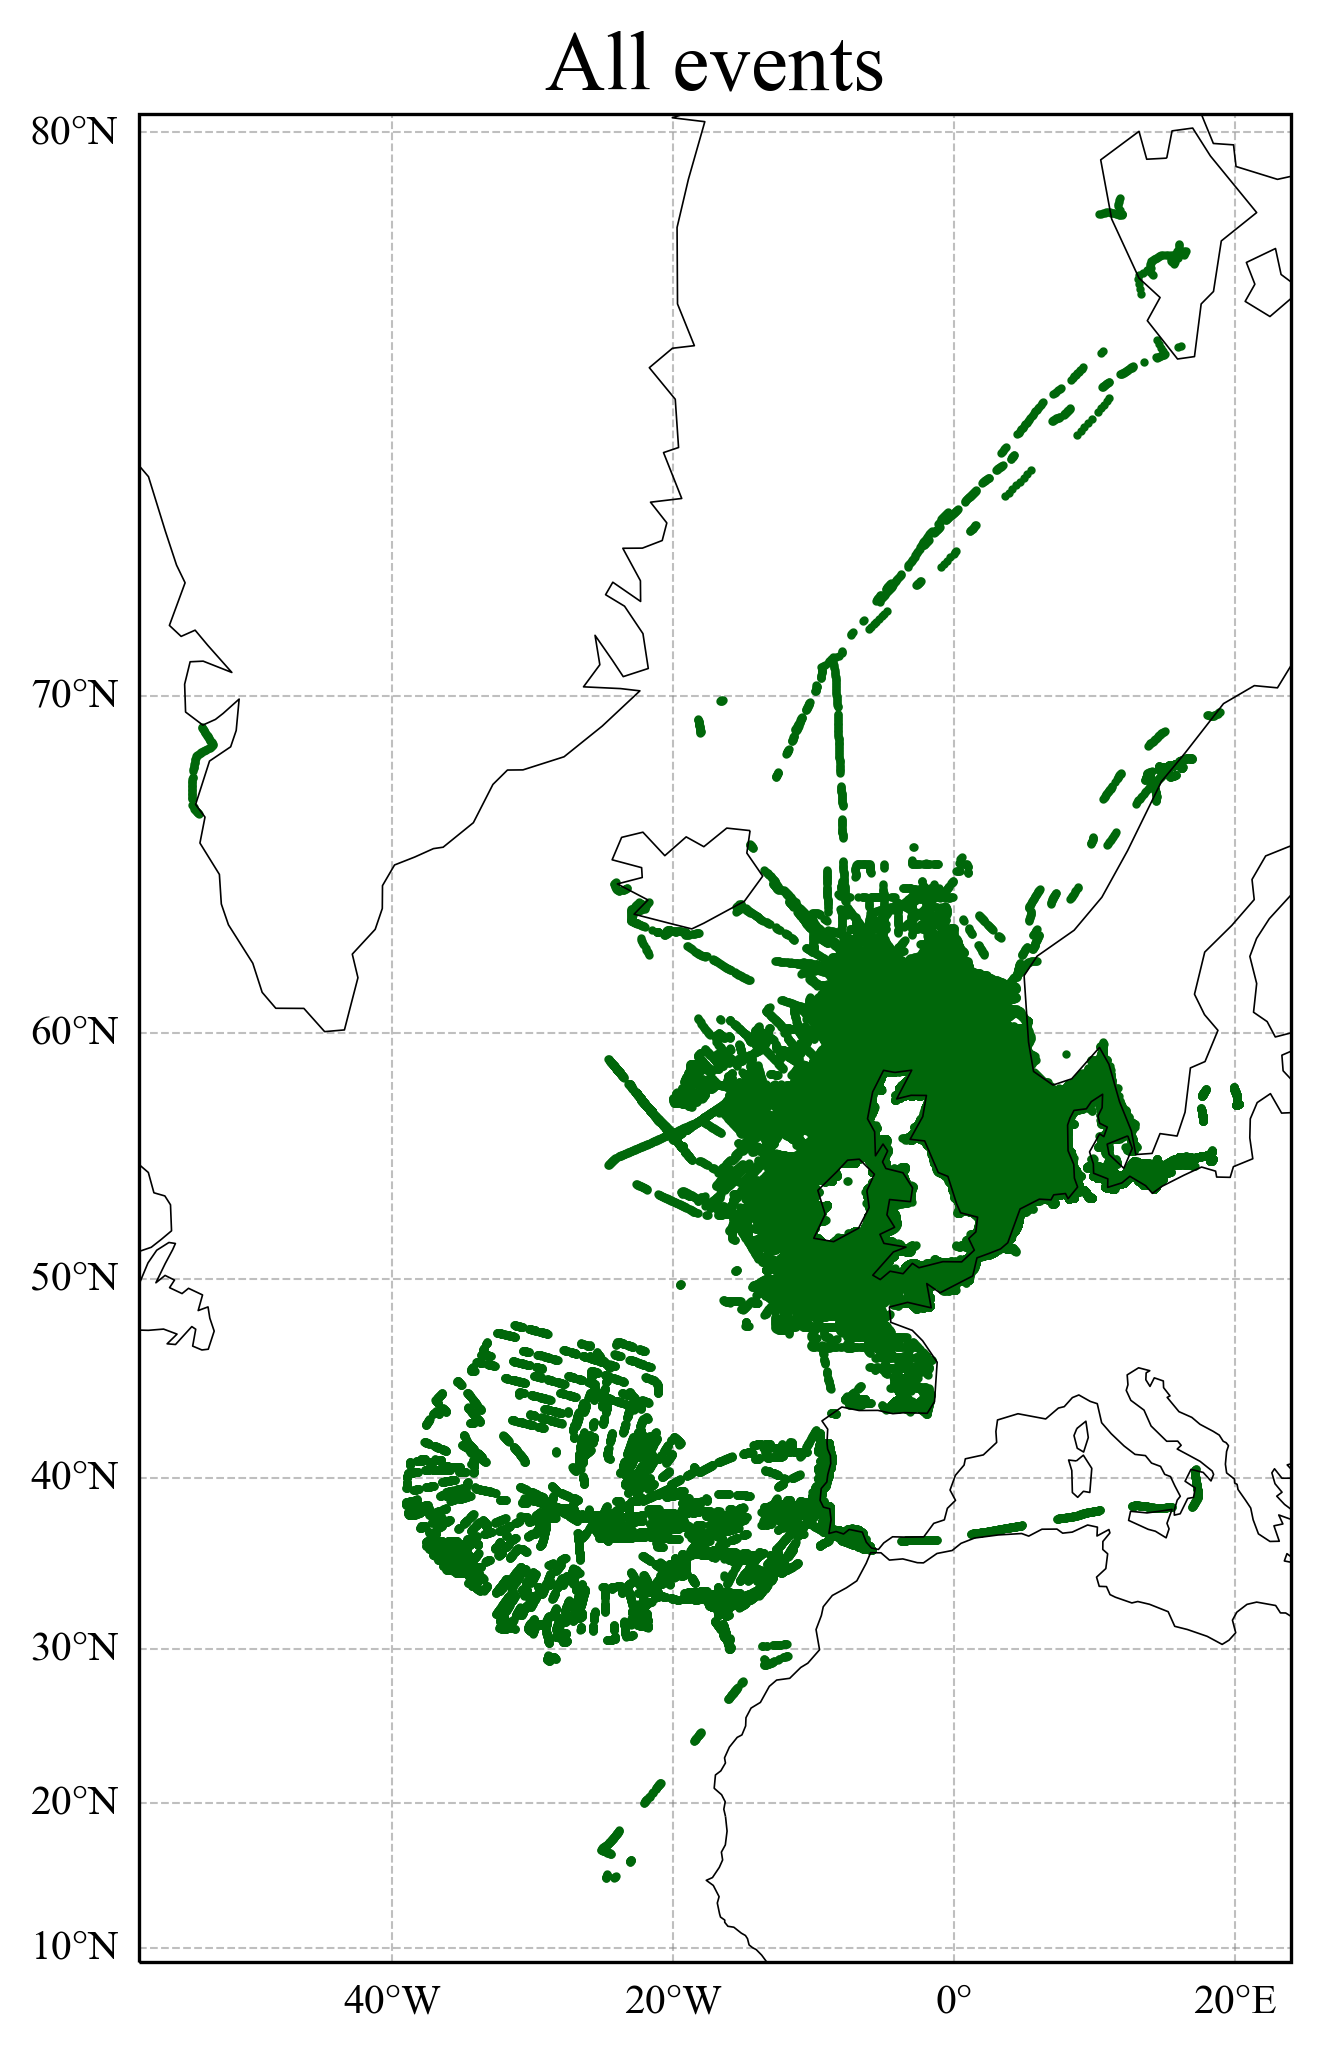

PyObject Text(0.5, 1.000523384108006, 'All events')

In [229]:
if doplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=ccrs.Mercator())
    ax.plot(events.decimalLongitude, events.decimalLatitude, "o", 
        color="#00670A", ms=1, transform=datacrs, zorder=3)
    ax.coastlines(lw=.4, zorder=4)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=0.5, linestyle="--")
    gl.xlabels_top = false
    gl.ylabels_right = false
    ax.set_title("All events")
end

In [240]:
eventID = collect(keys(total_count));

In [279]:
open(fname, "w") do ds
    for eee in eventID
        
        theevent = first(events[events.id .== eee,:])
        write(ds, "$(theevent.decimalLongitude)\t $(theevent.decimalLatitude)\t $(theevent.eventDate)\t $(total_count[eee])\n")
    end
end